# Boolean Networks - Assignment 3

In [1]:
# 🟢 Setup and Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

# 🟢 Helper class to build and simulate boolean network

class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                # print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)

## Model Setup

### Default Model
The default model is defined with the following rules:
- `DNA_damage = INPUT (constant)`
- `p21 = p53`
- `MYC = (NOT p53) AND (NOT p21)`
- `CDK2 = MYC AND (NOT p21) AND (NOT p53)`
- `MDM2 = MYC`
- `p53 = DNA_damage AND (NOT MDM2)`
- `Growth = CDK2 AND MYC AND (NOT p53)`
- `Death = p53 AND DNA_damage AND (NOT Growth)`

### Mutations
The following mutations are applied to the default model to simulate different scenarios:

- **Mutation A: p53 Knockout (Loss of tumor suppressor)**  
    `p53 = BROKEN (always OFF)`

- **Mutation B: MYC Amplification (Oncogene overexpression)**  
    `MYC = AMPLIFIED (always ON)`

- **Mutation C: MDM2 Overexpression (p53 pathway disruption)**  
    `MDM2 = OVEREXPRESSED (always ON)`

- **Mutation D: CDK2 Knockout**  
    `CDK2 = KNOCKOUT (always OFF)`


In [3]:
# Helper function to create a network with default rules
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
def create_default_network():
    network = BooleanNetwork(nodes)
    network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
    network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
    network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
    network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
    network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
    network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
    network.add_rule('Growth', lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
    network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

    return network

# Default model setup
network_default = create_default_network()

# Mutation A: p53 Knockout (Loss of tumor suppressor)
network_A = create_default_network()
network_A.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)")

# Mutation B: MYC Amplification (Oncogene overexpression)
network_B = create_default_network()
network_B.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED(always ON)")

# Mutation C: MDM2 Overexpression (p53 pathway disruption)
network_C = create_default_network()
network_C.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)")

# Mutation D: MDM2 broken (Custom mutation)
network_D = create_default_network()
network_D.add_rule('MDM2', lambda s: False, "MDM2 = BROKEN (always OFF)")


## Scenario Analysis

Scenarios:
*   Healthy Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Stressed Cell (Repairable): `{'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`
*   Oncogene Hijacked Cell: `{'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}`

For each scenario, we analyze the final growth, death and p53 state.

In [4]:
scenarios = {
    "Healthy Cell": {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    "Stressed Cell (Repairable)": {'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0,'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    "Oncogene Hijacked Cell": {'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

networks = {
    "Default": network_default,
    "Mutation A (p53 KO)": network_A,
    "Mutation B (MYC Amp)": network_B,
    "Mutation C (MDM2 OE)": network_C,
    "Mutation D (MDM2 KO)": network_D
}

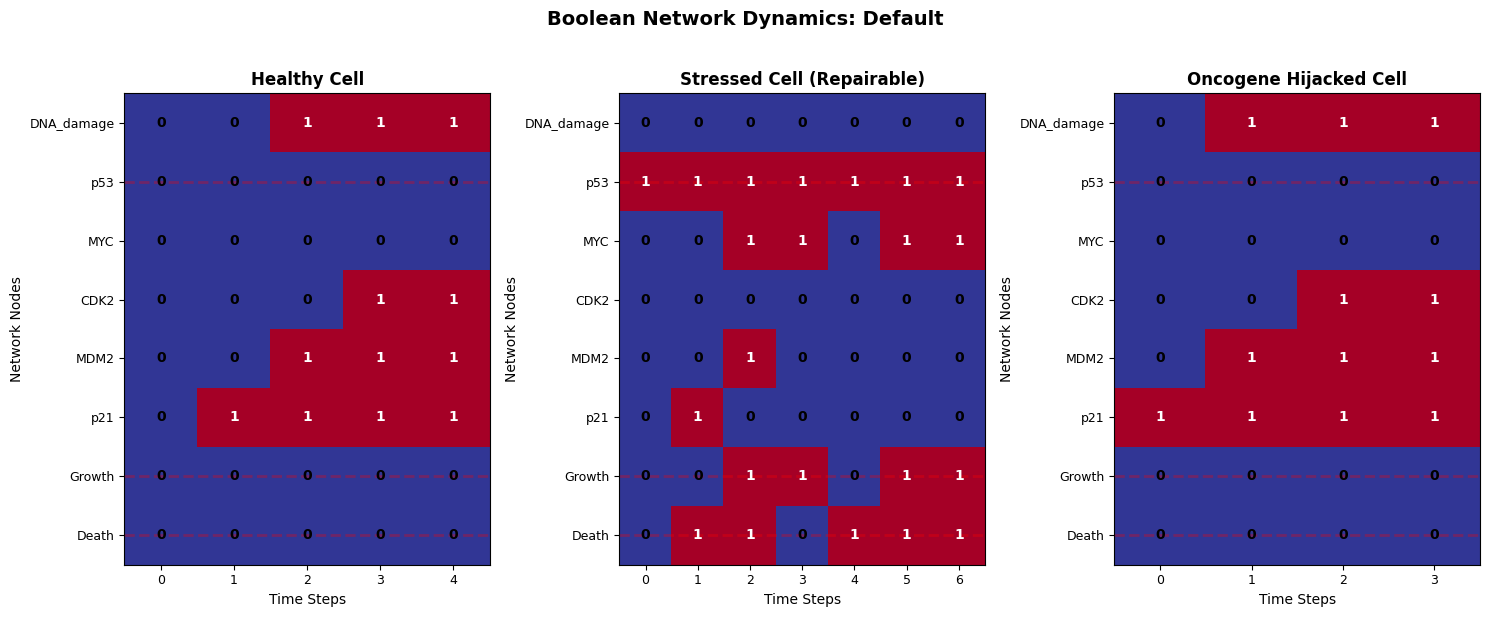

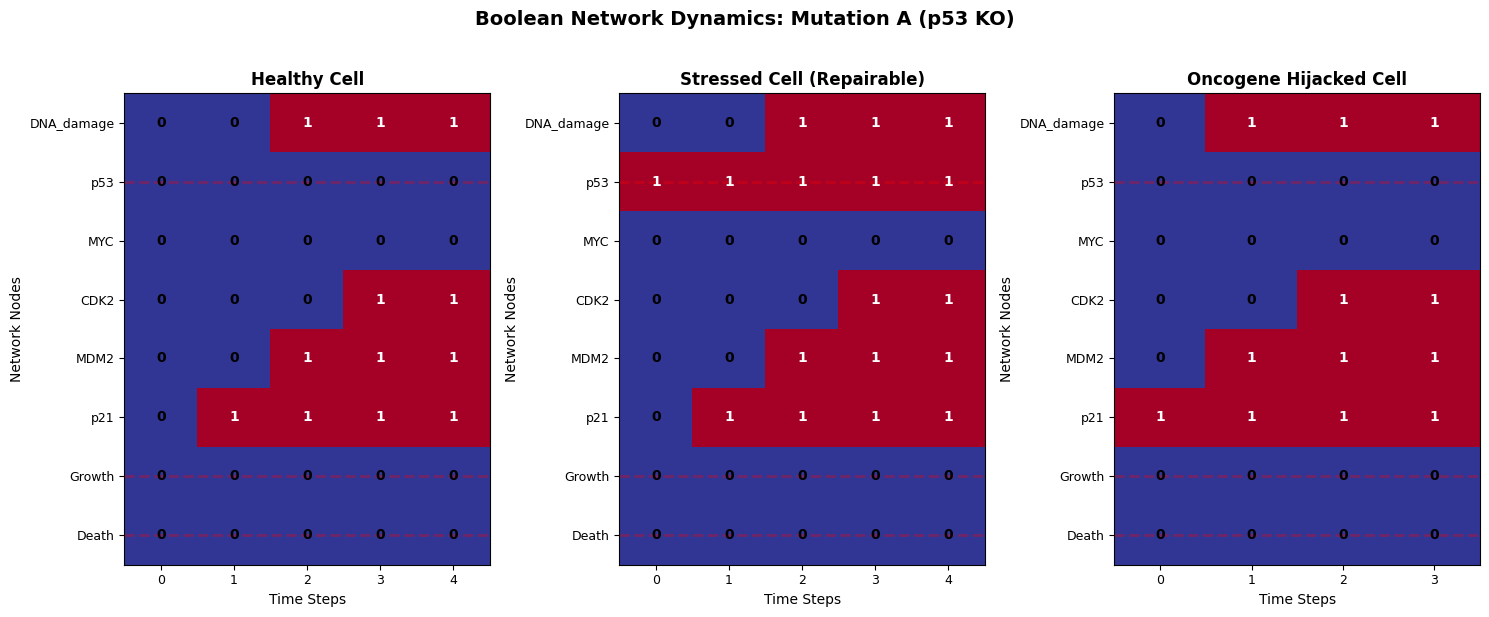

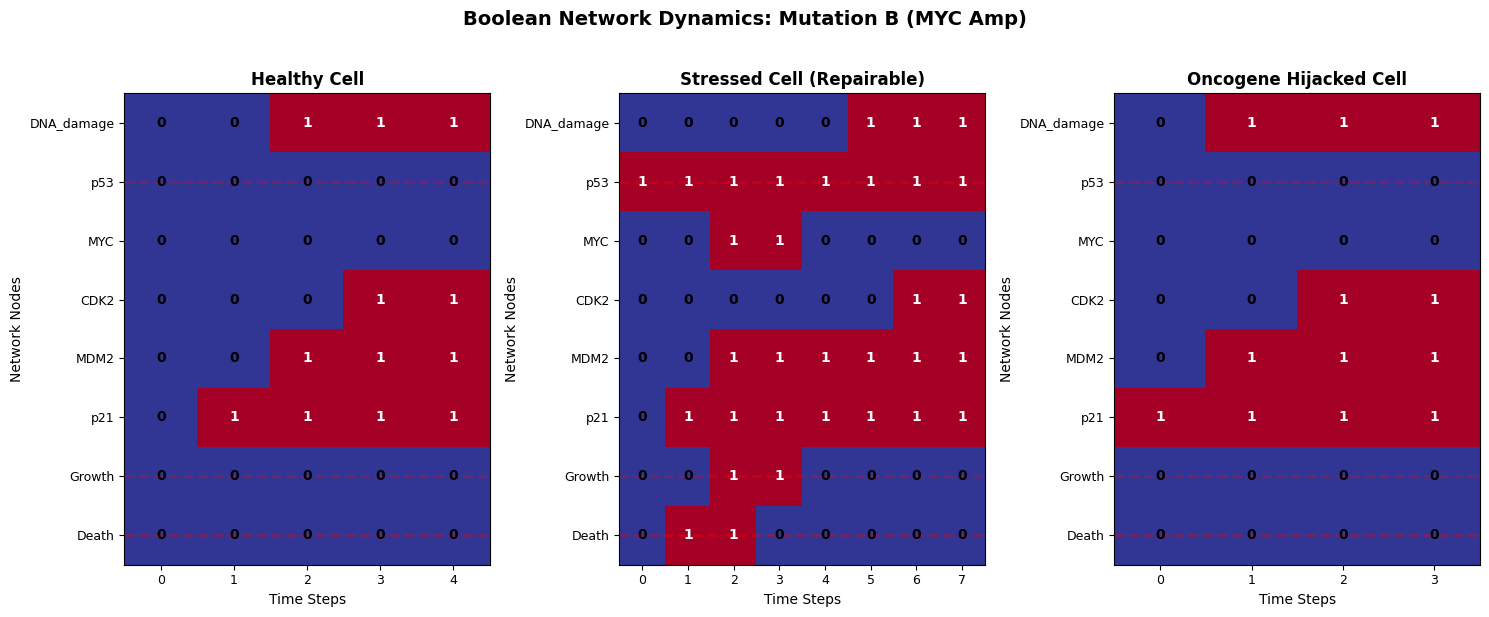

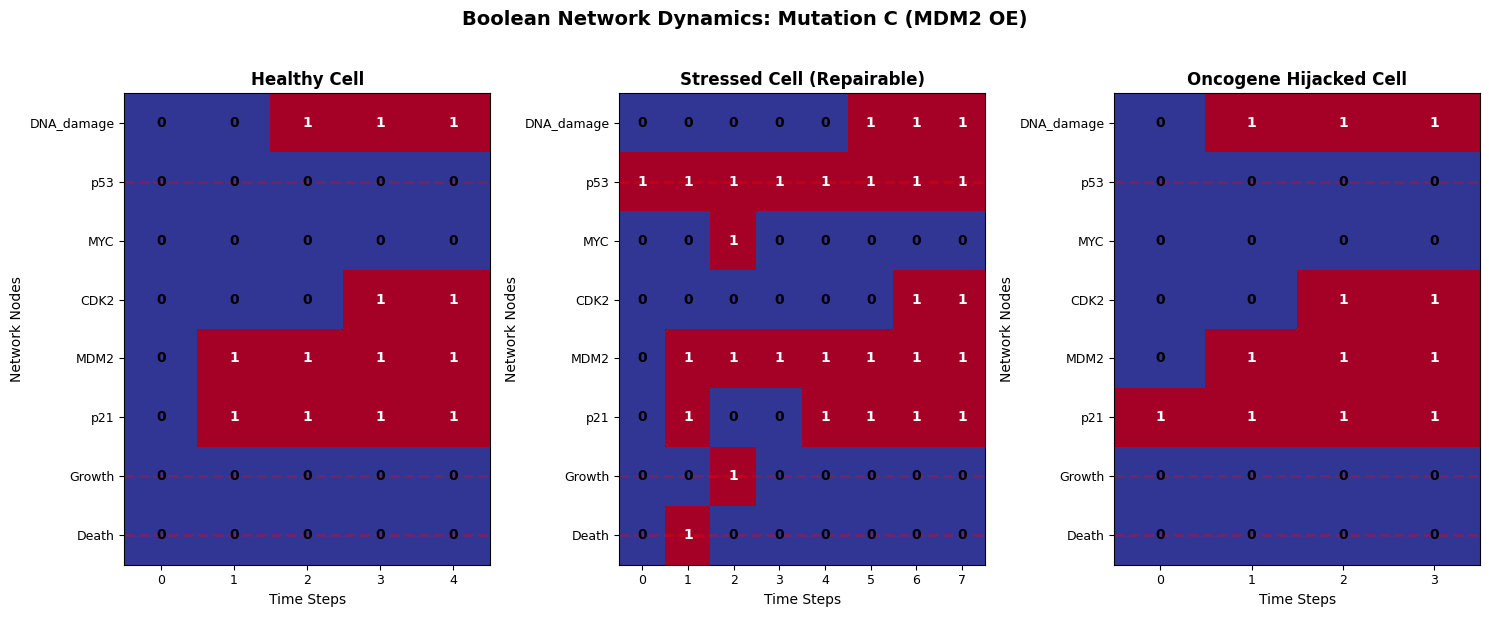

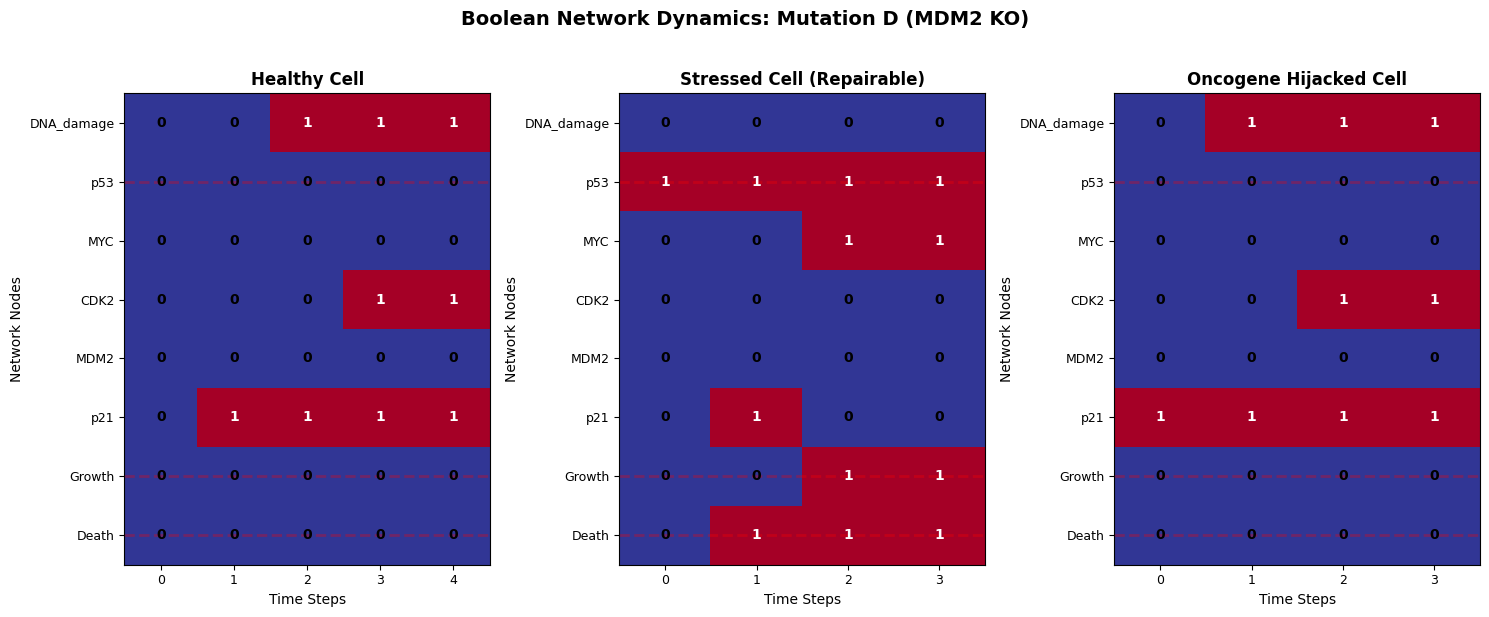

In [5]:
# Simulate and visualize results
n_scenarios = len(scenarios)

# Iterate through each network model and visualize results
for net_name, net in networks.items():
    fig, axes = plt.subplots(1, n_scenarios, figsize=(5 * n_scenarios, 6))
    if n_scenarios == 1:
        axes = [axes]

    for scenario_idx, scenario_name in enumerate(scenarios.keys()):
        ax = axes[scenario_idx]

        # Simulate the network for the given scenario
        net.set_state(**scenarios[scenario_name])
        trajectory = net.simulate(steps=8)
        trajectory_matrix = np.array(trajectory).T  # Transpose for proper orientation

        # Create heatmap
        im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

        # Formatting
        ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Time Steps', fontsize=10)
        ax.set_ylabel('Network Nodes', fontsize=10)
        ax.set_yticks(range(len(nodes)))
        ax.set_yticklabels(nodes, fontsize=9)

        # Set x-axis ticks to integers
        ax.set_xticks(range(trajectory_matrix.shape[1]))
        ax.set_xticklabels(range(trajectory_matrix.shape[1]), fontsize=9)

        # Add text annotations
        for t in range(trajectory_matrix.shape[1]):
            for n in range(len(nodes)):
                color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
                ax.text(t, n, str(int(trajectory_matrix[n, t])),
                        ha="center", va="center", color=color, fontweight='bold')

        # Highlight key output nodes
        output_indices = [i for i, name in enumerate(nodes) if name in ['Growth', 'Death', 'p53']]
        for output_idx in output_indices:
            ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

    plt.suptitle(f'Boolean Network Dynamics: {net_name}', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

## Attractor Analysis

In [6]:
def find_attractors(network, max_steps, node_names):
    attractors = []
    print(f"Testing all {2**len(node_names)} possible initial states...")

    for initial_state in list(product([0, 1], repeat=len(node_names))):
        # Set the network to this initial state
        state_dict = {node_names[i]: initial_state[i] for i in range(len(node_names))}
        network.set_state(**state_dict)

        # Simulate the network
        trajectory = network.simulate(steps=max_steps)

        # Check if it reached a steady state (last two states are the same)
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

            # Check if this is a new attractor
            if final_state not in attractors:
                attractors.append(final_state)

                state_dict = {node_names[j]: final_state[j] for j in range(len(node_names))}
                print(f"\nAttractor {len(attractors)}: {list(final_state)}")

                # Analyze the biological meaning
                growth_active = state_dict['Growth'] == 1
                death_active = state_dict['Death'] == 1
                p53_active = state_dict['p53'] == 1
                dna_damage_active = state_dict['DNA_damage'] == 1


                print(f"   Growth: {'ON' if growth_active else 'OFF'}")
                print(f"   Death: {'ON' if death_active else 'OFF'}")
                print(f"   p53: {'ON' if p53_active else 'OFF'}")
                print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

                # TODO: Interpret the meaning
                if growth_active and not death_active and not dna_damage_active:
                    interpretation = "Normal growth"
                elif death_active and not growth_active:
                    interpretation = "Cell death"
                elif growth_active and not death_active and dna_damage_active:
                    interpretation = "Growth with DNA damage - Potentially tumorous, uncontrolled growth"
                else:
                    interpretation = "CONFLICT - Unusual state"

                print(f"   → {interpretation}")
                
    return attractors



In [7]:
def analyze_basins_of_attraction(network, node_names, attractors, max_steps):
    n_nodes = len(node_names)
    basin_data = defaultdict(list)  # attractor -> list of initial states
    attractor_map = {}  # initial_state -> attractor_index

    for initial_state in product([0, 1], repeat=n_nodes):
        # Set network state
        state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
        network.set_state(**state_dict)

        # Simulate
        trajectory = network.simulate(steps=max_steps, record_history=True)

        # Find which attractor this leads to
        if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
            final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

            # Find matching attractor
            for att_idx, attractor in enumerate(attractors):
                clean_attractor = tuple(int(x) for x in attractor)
                if final_state == clean_attractor:
                    basin_data[att_idx].append(initial_state)
                    attractor_map[initial_state] = att_idx
                    break

    # Display basin sizes
    print(f"\n Basin Sizes:")
    total_states = len(list(product([0, 1], repeat=n_nodes)))
    for att_idx in range(len(attractors)):
        basin_size = len(basin_data[att_idx])
        percentage = (basin_size / total_states) * 100
        print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

    return basin_data, attractor_map



In [8]:
def visualize_basins_and_attractors(basin_data, attractors, node_names):
    
    # Create pie chart of basin sizes
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Pie chart of basin sizes
    basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
    basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
    colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

    wedges, texts, autotexts = ax1.pie(basin_sizes,
                                       labels=basin_labels,
                                       colors=colors,
                                       autopct='%1.1f%%',
                                       startangle=90)

    ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
                  fontsize=12, fontweight='bold')

    # Bar chart comparison
    attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
    bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

    ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Number of Initial States', fontsize=10)
    ax2.set_xlabel('Attractors', fontsize=10)

    # Add value labels on bars
    for bar, size in zip(bars, basin_sizes):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}',
                 ha='center', va='bottom', fontweight='bold')

    # Convert attractors to clean matrix
    attractor_matrix = []
    for attractor in attractors:
        clean_row = [int(x) for x in attractor]
        attractor_matrix.append(clean_row)
    attractor_matrix = np.array(attractor_matrix)

    # Create heatmap in ax3
    sns.heatmap(attractor_matrix,
                xticklabels=node_names,
                yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                cmap='RdYlBu_r',
                cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                annot=True,
                fmt='d',
                linewidths=0.5,
                ax=ax3)

    ax3.set_title('Boolean Network Attractors: Final States Comparison',
                  fontsize=12, fontweight='bold')
    ax3.set_xlabel('Network Nodes', fontsize=10)
    ax3.set_ylabel('Attractors', fontsize=10)

    # Highlight key output nodes
    output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
    for node in output_nodes:
        if node in node_names:
            idx = node_names.index(node)
            ax3.axvline(x=idx + 0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

    plt.tight_layout()
    plt.show()



====== Analyzing Default Network Model ======

Testing all 256 possible initial states...

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Cell death

Attractor 3: [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth with DNA damage - Potentially tumorous, uncontrolled growth

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 120 states ( 46.9%)
   Attractor 3:   8 states (  3.1%)


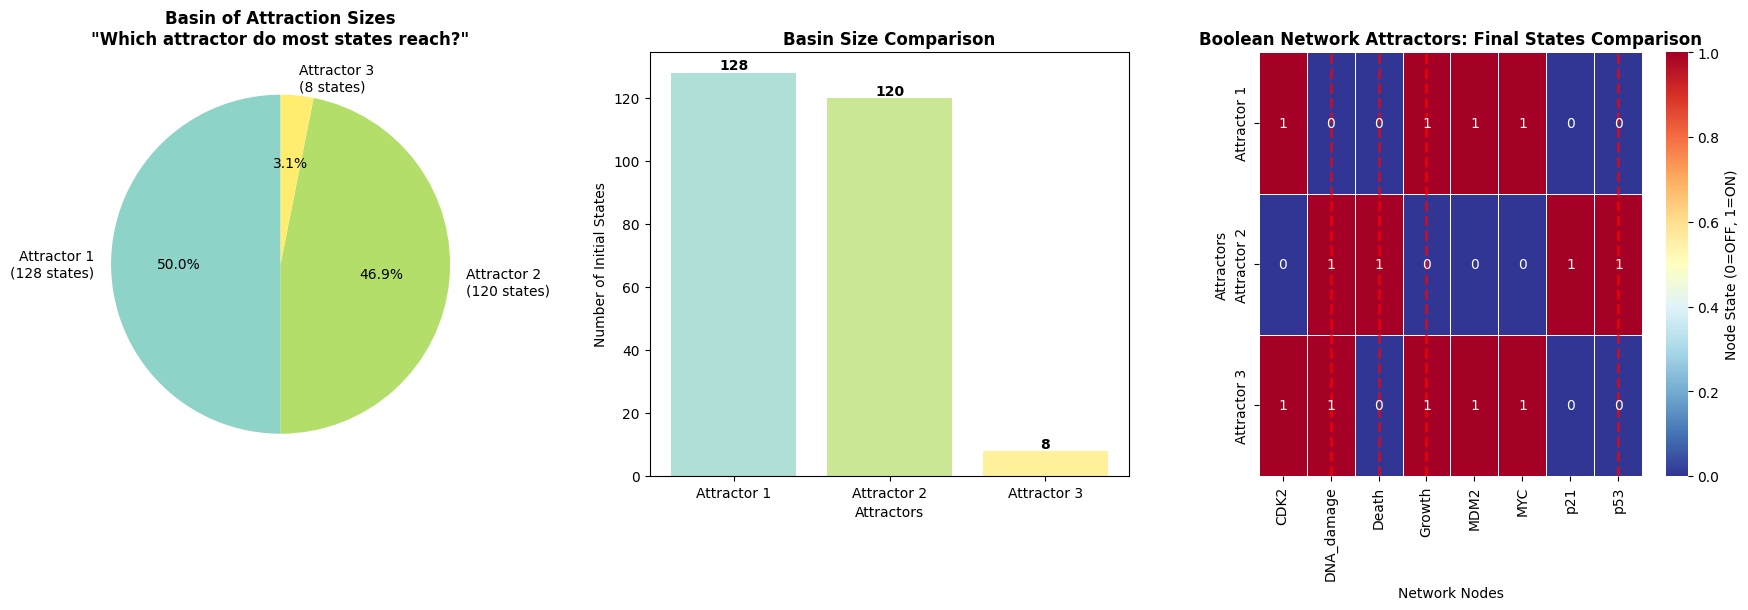


====== Analyzing Mutant Network Model A ======

Testing all 256 possible initial states...

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth with DNA damage - Potentially tumorous, uncontrolled growth

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 128 states ( 50.0%)


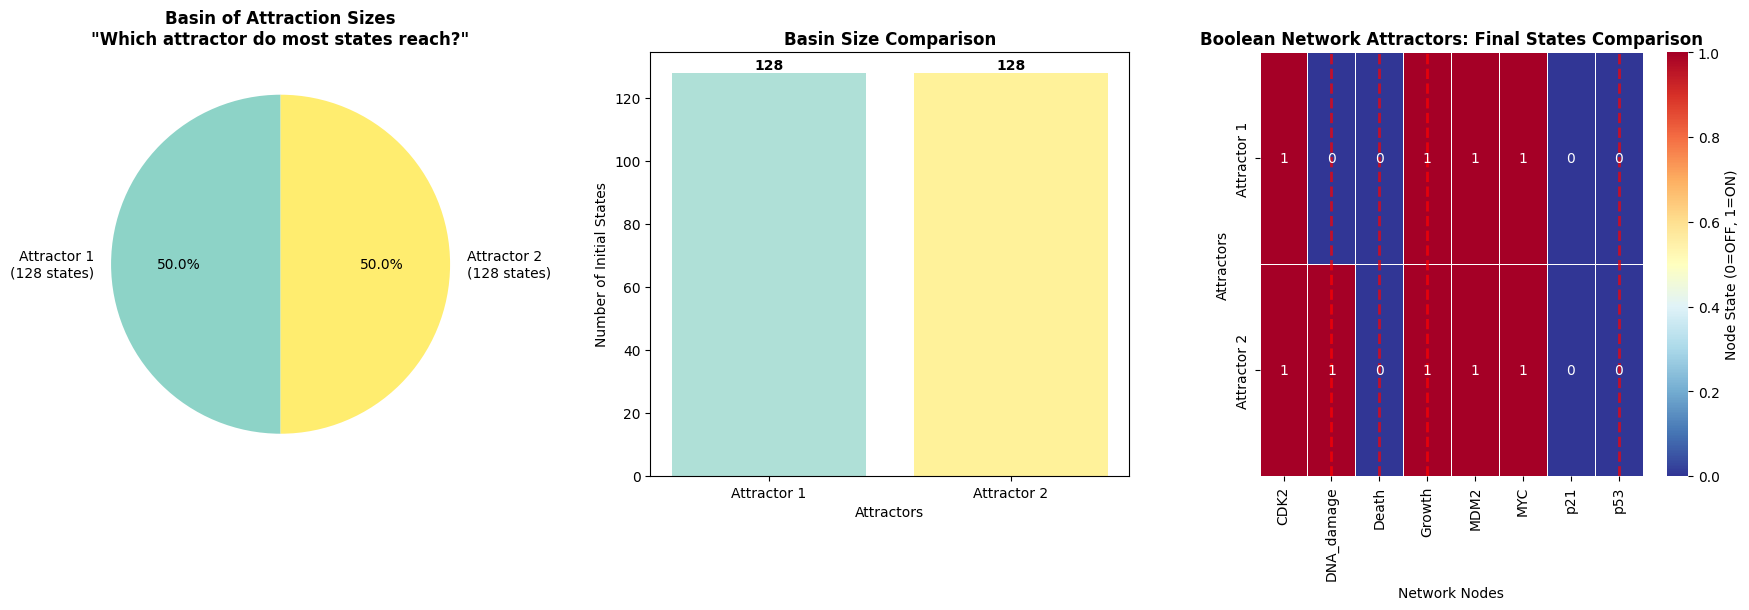


====== Analyzing Mutant Network Model B ======

Testing all 256 possible initial states...

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth with DNA damage - Potentially tumorous, uncontrolled growth

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 128 states ( 50.0%)


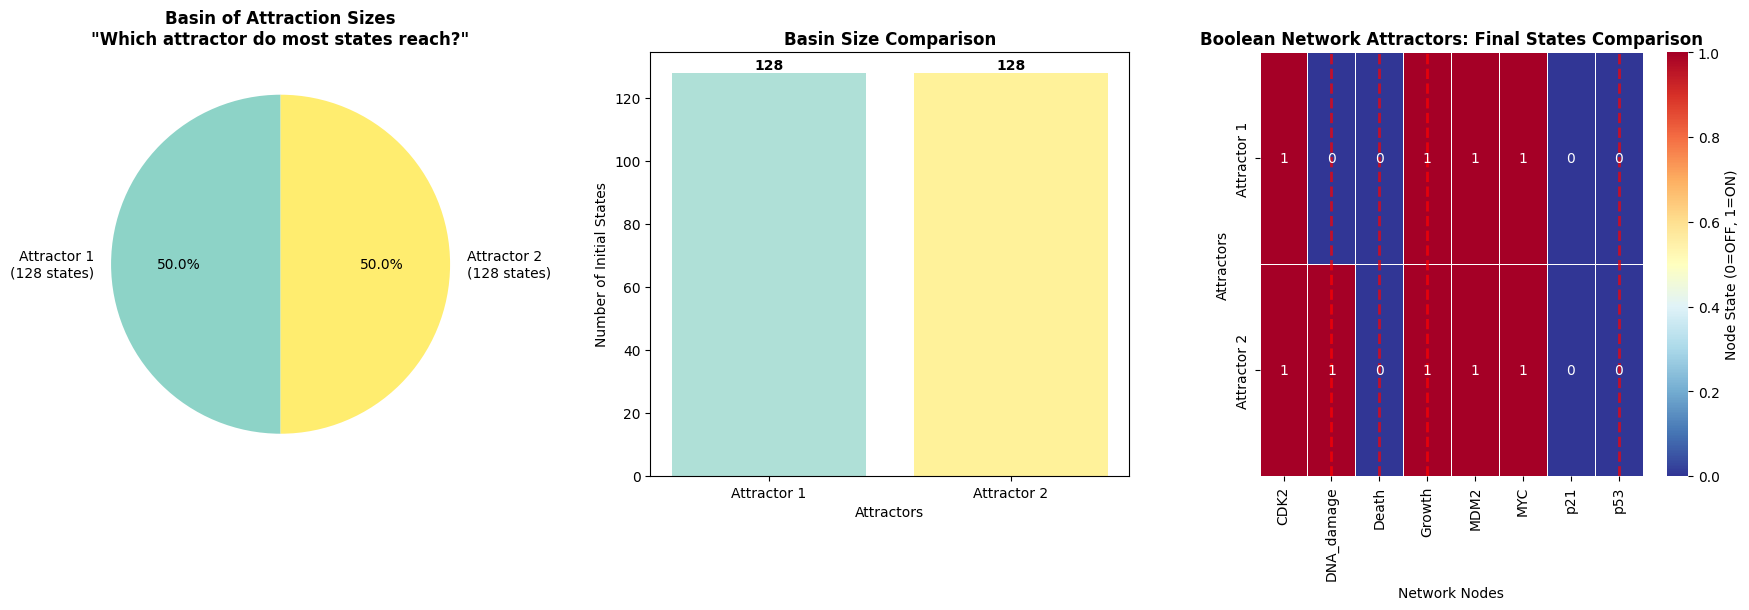


====== Analyzing Mutant Network Model C ======

Testing all 256 possible initial states...

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth with DNA damage - Potentially tumorous, uncontrolled growth

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 128 states ( 50.0%)


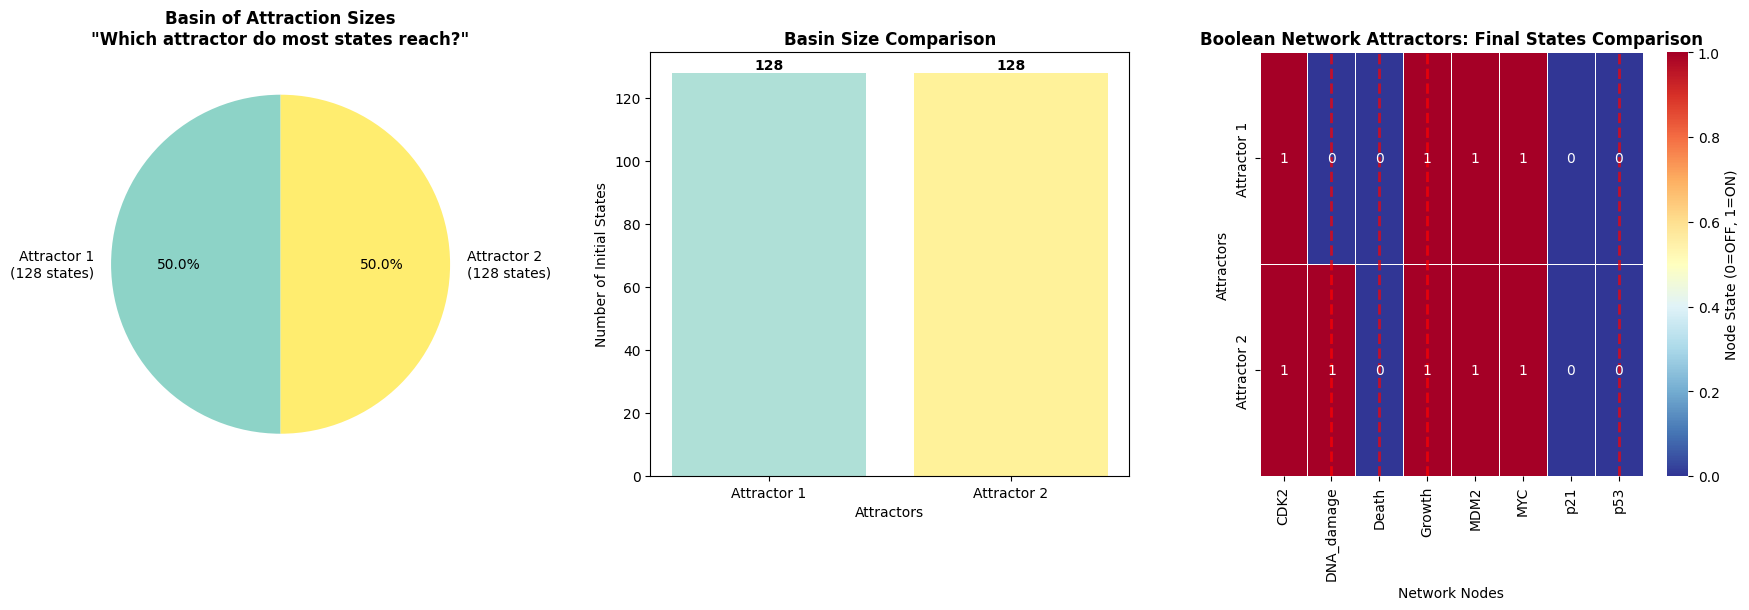


====== Analyzing Mutant Network Model D ======

Testing all 256 possible initial states...

Attractor 1: [np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(0), np.int64(1), np.int64(0), np.int64(0)]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Normal growth

Attractor 2: [np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(0), np.int64(1), np.int64(1)]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → Cell death

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 128 states ( 50.0%)


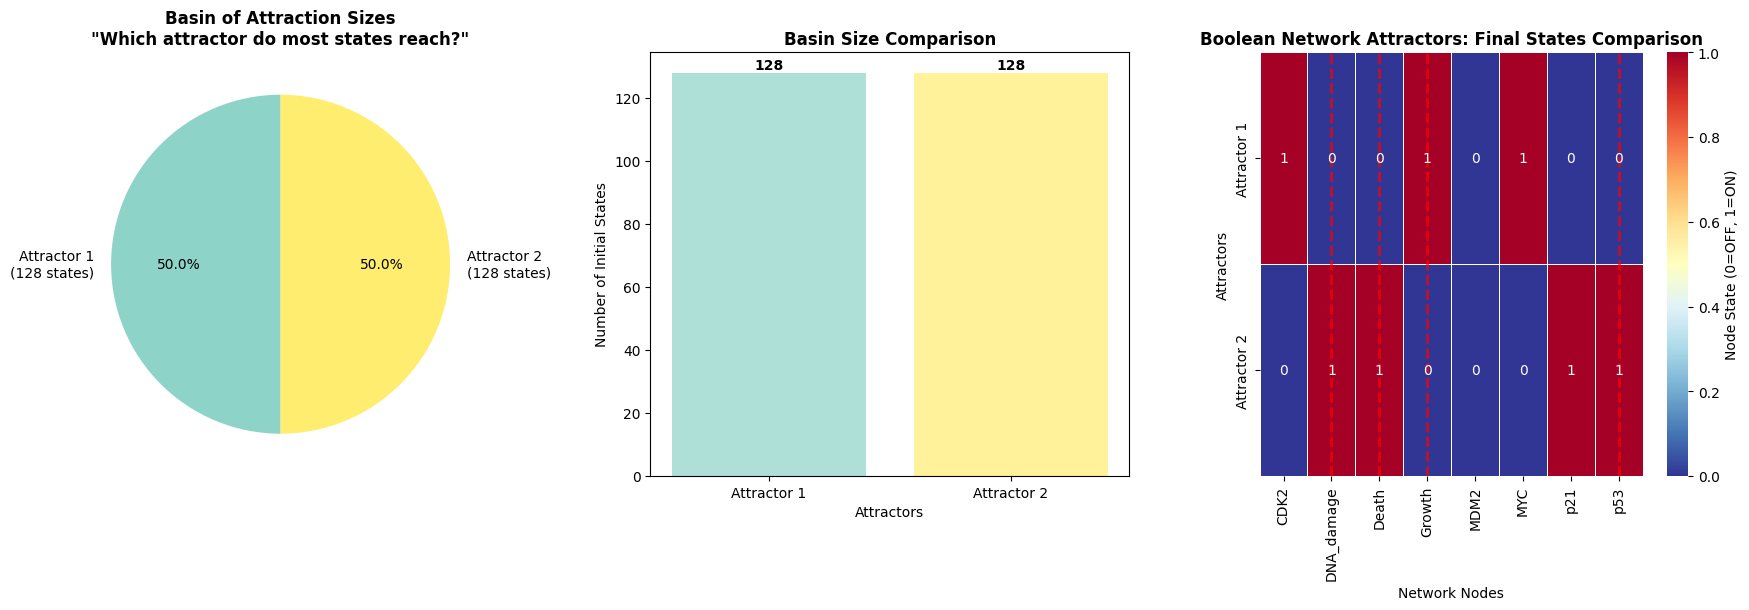

In [9]:

max_steps = 50
node_names = sorted(network_default.nodes.keys())

print("\n====== Analyzing Default Network Model ======\n")
attractors = find_attractors(network_default, max_steps, node_names)
basin_data, attractor_map = analyze_basins_of_attraction(network_default, node_names, attractors, max_steps)
visualize_basins_and_attractors(basin_data, attractors, node_names)

print("\n====== Analyzing Mutant Network Model A ======\n")
attractors = find_attractors(network_A, max_steps, node_names)
basin_data, attractor_map = analyze_basins_of_attraction(network_A, node_names, attractors, max_steps)
visualize_basins_and_attractors(basin_data, attractors, node_names)

print("\n====== Analyzing Mutant Network Model B ======\n")
attractors = find_attractors(network_B, max_steps, node_names)
basin_data, attractor_map = analyze_basins_of_attraction(network_B, node_names, attractors, max_steps)
visualize_basins_and_attractors(basin_data, attractors, node_names)

print("\n====== Analyzing Mutant Network Model C ======\n")
attractors = find_attractors(network_C, max_steps, node_names)
basin_data, attractor_map = analyze_basins_of_attraction(network_C, node_names, attractors, max_steps)
visualize_basins_and_attractors(basin_data, attractors, node_names)

print("\n====== Analyzing Mutant Network Model D ======\n")
attractors = find_attractors(network_D, max_steps, node_names)
basin_data, attractor_map = analyze_basins_of_attraction(network_D, node_names, attractors, max_steps)
visualize_basins_and_attractors(basin_data, attractors, node_names)